In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.layers import Input

Using TensorFlow backend.


In [2]:
driving_log = pd.read_csv("data/driving_log.csv")

In [3]:
driving_log.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [4]:
n_train = len(driving_log)
print("Number of training examples =", n_train)

Number of training examples = 8036


In [5]:
central_images = driving_log["center"]
central_images.head()

0    IMG/center_2016_12_01_13_30_48_287.jpg
1    IMG/center_2016_12_01_13_30_48_404.jpg
2    IMG/center_2016_12_01_13_31_12_937.jpg
3    IMG/center_2016_12_01_13_31_13_037.jpg
4    IMG/center_2016_12_01_13_31_13_177.jpg
Name: center, dtype: object

In [6]:
X = [mpimg.imread("data/" + row) for row in central_images]
y = driving_log['steering']

X = np.array(X)
y = np.array(y)

Steering angle: 0.1765823
Image dimensions: (160, 320, 3)
Output dimensions: (8036,)


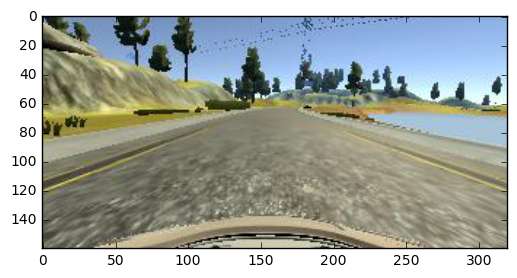

In [7]:
index = random.randint(0, n_train)
image = X[index].squeeze()
image_dims = image.shape
output_dims = y.shape

plt.imshow(image)
print("Steering angle: {}".format(y[index]))
print("Image dimensions: {}".format(image_dims))
print("Output dimensions: {}".format(output_dims))

In [8]:
X, y = shuffle(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [9]:
print(X.shape)
print(y.shape)

(8036, 160, 320, 3)
(8036,)


In [10]:
input_tensor = Input(shape=image_dims)
base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = False

In [11]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1)(x)
model = Model(input=base_model.input, output=predictions)

In [12]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='mean_squared_error', metrics=['accuracy'])


batch_size = 100
nb_epoch = 10


model.fit(X_train, y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_split=0.1)

Train on 5785 samples, validate on 643 samples
Epoch 1/10
5785/5785 [==============================] - 2785s - loss: 0.2313 - acc: 0.4022 - val_loss: 0.3690 - val_acc: 0.3281
Epoch 2/10
5785/5785 [==============================] - 2795s - loss: 0.1841 - acc: 0.4346 - val_loss: 0.1583 - val_acc: 0.4277
Epoch 3/10
5785/5785 [==============================] - 2623s - loss: 0.1677 - acc: 0.4479 - val_loss: 0.1253 - val_acc: 0.4541
Epoch 4/10
5785/5785 [==============================] - 2620s - loss: 0.1459 - acc: 0.4595 - val_loss: 0.1179 - val_acc: 0.4557
Epoch 5/10
5785/5785 [==============================] - 2628s - loss: 0.1381 - acc: 0.4693 - val_loss: 0.1100 - val_acc: 0.4588
Epoch 6/10
5785/5785 [==============================] - 2605s - loss: 0.1308 - acc: 0.4740 - val_loss: 0.0993 - val_acc: 0.4666
Epoch 7/10
5785/5785 [==============================] - 2608s - loss: 0.1224 - acc: 0.4748 - val_loss: 0.1207 - val_acc: 0.4821
Epoch 8/10
5785/5785 [==============================] - 2

In [13]:
model.save_weights("model.h5")

# Save model config (architecture)
json_string = model.to_json()
with open("model.json", "w") as f:
    f.write(json_string)  